In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from numba import jit
import pandas as pd

In [ ]:
digits_dataset = datasets.load_digits(return_X_y=True)
digits_dataset

(array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 array([0, 1, 2, ..., 8, 9, 8]))

In [ ]:
digits_dataset_X = digits_dataset[0]
digits_dataset_X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [ ]:
digits_dataset_y = digits_dataset[1]
digits_dataset_y

array([0, 1, 2, ..., 8, 9, 8])

In [ ]:
size = len(digits_dataset_X)
size

1797

Attributes:  [ 0.  0.  0.  8. 15.  4.  0.  0.  0.  0.  3. 16. 10. 11.  0.  0.  0.  0.
  6. 12. 11. 13.  0.  0.  0.  0. 10. 16. 16.  9.  0.  0.  0.  1. 16. 12.
 11.  5.  0.  0.  0.  2. 13.  0.  2.  9.  0.  0.  0.  0.  8.  6.  2. 12.
  0.  0.  0.  0.  1.  9. 14.  9.  0.  0.]
Label:  8


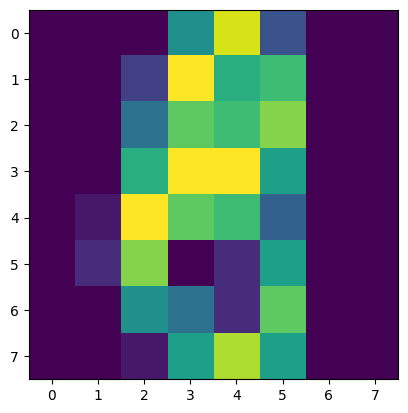

In [ ]:
digits_to_show = np.random.choice(range(size), 1)[0]
print("Attributes: ", digits_dataset_X[digits_to_show])
print("Label: ", digits_dataset_y[digits_to_show])
plt.imshow(np.reshape(digits_dataset_X[digits_to_show], (8, 8)))
plt.show()

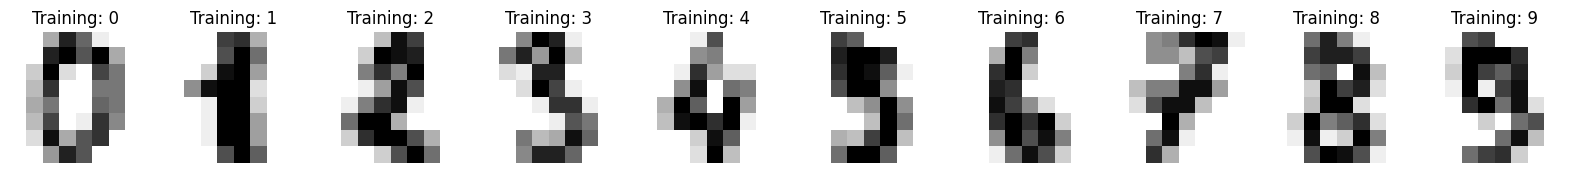

In [ ]:
digits = datasets.load_digits()
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 10))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [ ]:
X, y = datasets.load_digits(return_X_y=True)
indices = np.random.permutation(len(X))
X_shuffled = X[indices]
y_shuffled = y[indices]
X_shuffled

array([[ 0.,  1., 11., ..., 15., 11.,  0.],
       [ 0.,  0.,  8., ...,  0.,  0.,  0.],
       [ 0.,  4., 16., ...,  7.,  4.,  0.],
       ...,
       [ 0.,  0.,  4., ...,  0.,  0.,  0.],
       [ 0.,  1.,  8., ...,  5.,  0.,  0.],
       [ 0.,  0.,  1., ...,  3.,  0.,  0.]])

In [ ]:
def normalize(train, test, epsilon=1e-10):
    min_val = np.min(train, axis=0)
    max_val = np.max(train, axis=0)
    train_norm = (train - min_val) / (max_val - min_val + epsilon)
    test_norm = (test - min_val) / (max_val - min_val + epsilon)
    return train_norm, test_norm

In [ ]:
def accuracy(Y, predictions):
    true_labels = np.argmax(Y, axis=1) + 1
    accuracy = np.mean(predictions == true_labels)
    return accuracy * 100

def f1_score(Y, predictions):
    true_labels = np.argmax(Y, axis=1) + 1
    classes = np.unique(true_labels)
    f1_scores = []
    for c in classes:
        tp = np.sum((predictions == c) & (true_labels == c))
        fp = np.sum((predictions == c) & (true_labels != c))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        fn = np.sum((predictions != c) & (true_labels == c))
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    avg_f1 = np.mean(f1_scores) * 100
    return avg_f1

In [ ]:
def stratified_cross_validation(features, labels, k=10):
    label_indices = [np.where(labels == label)[0] for label in np.unique(labels)]
    folds = []
    pairs = []
    shuffled_label_indices = [np.random.permutation(label_list) for label_list in label_indices]
    label_splits = [np.array_split(label_list, k) for label_list in shuffled_label_indices]
    for fold_parts in zip(*label_splits):
        fold = np.concatenate(fold_parts)
        folds.append(fold)
    for fold_index in range(k):
        test_fold = folds[fold_index]
        train_fold = np.concatenate([folds[i] for i in range(k) if i != fold_index])
        pairs.append((train_fold, test_fold))
    return pairs

# Neural Network Algorithm

Please note that we used Cyril's implementation of NN here.

In [ ]:
class NN:
    def __init__(self, sizes, initial_weights=None, eta=0.01, reg_lambda=0.01, use_softmax=False):
        self.sizes = sizes
        self.eta = eta
        self.reg_lambda = reg_lambda
        self.use_softmax = use_softmax
        self.weights = self.init_weights() if initial_weights is None else initial_weights

    def init_weights(self):
        return [np.random.randn(y, x + 1) * 0.1 for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def add_bias(self, X):
        return np.insert(X, 0, 1, axis=1)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        act = [self.add_bias(X)]
        ll = []
        for index, weight in enumerate(self.weights[:-1]):
            ll.append(act[-1] @ weight.T)
            act.append(self.add_bias(1 / (1 + np.exp(-ll[-1]))))
        ll.append(act[-1] @ self.weights[-1].T)
        act.append(self.softmax(ll[-1]) if self.use_softmax else 1 / (1 + np.exp(-ll[-1])))
        return act, ll

    def cost(self, Y, act):
        xq = Y.shape[0]
        return -np.sum(Y * np.log(act[-1] + 1e-8)) / xq if self.use_softmax else -np.sum(Y * np.log(act[-1]) + (1 - Y) * np.log(1 - act[-1])) / xq

    def backward(self, targets, activations, weights):
        num_samples = targets.shape[0]
        errors = [activations[-1] - targets]
        gradients = []
        for i in range(len(weights) - 1, 0, -1):
            delta = (errors[0] @ weights[i][:, 1:]) * activations[i][:, 1:] * (1 - activations[i][:, 1:])
            errors.insert(0, delta)
        for i in range(len(weights)):
            grad = errors[i].T @ activations[i] / num_samples
            gradients.append(grad)
        return errors, gradients

    def update_weights(self, gradients):
        for i in range(len(self.weights)):
            regularization_grad = (self.reg_lambda * self.weights[i]) / self.weights[i].shape[0]
            regularization_grad[:, 0] = 0
            self.weights[i] -= self.eta * (gradients[i] + regularization_grad)

    def predict(self, inputs):
        final_activations, _ = self.forward(inputs)
        return np.argmax(final_activations[-1], axis=1) + 1

    def train(self, inputs, labels, iterations):
        for _ in range(iterations):
            final_activations, _ = self.forward(inputs)
            _, weight_gradients = self.backward(labels, final_activations, self.weights)
            self.update_weights(weight_gradients)
        return self.weights


In [ ]:
y_encoder = OneHotEncoder(sparse=False)
y_encoded = y_encoder.fit_transform(y_shuffled.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_encoded, test_size=0.2, random_state=42)
X_train, X_test = normalize(X_train, X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
nn = NN([64, 32, 32, 10], eta=0.1, reg_lambda=0.05, use_softmax=True)
trained_weights = nn.train(X_train, y_train, iterations=10000)
train_predictions = nn.predict(X_train)
train_accuracy = accuracy(y_train, train_predictions)
print(f"Training Accuracy: {train_accuracy:.2f}%")
test_predictions = nn.predict(X_test)
test_accuracy = accuracy(y_test, test_predictions)
print(f"Testing Accuracy: {test_accuracy:.2f}%")

Training Accuracy: 94.92%
Testing Accuracy: 94.44%


In [ ]:
def test_hyperparameters(features, labels, k=10):
    eta_values = [0.05, 0.1, 0.2]
    reg_lambda_values = [0.01, 0.05, 0.1]
    layer_configurations = [
        [64, 16, 10] ,
        [64, 32, 10],
        [64, 16, 16, 10]
    ]
    results = []
    for eta in eta_values:
        for reg_lambda in reg_lambda_values:
            for layers in layer_configurations:
                train_accuracies = []
                train_f1_scores = []
                test_accuracies = []
                test_f1_scores = []
                splits = stratified_cross_validation(features, labels, k)
                for train_indices, test_indices in splits:
                    X_train, y_train = features[train_indices], labels[train_indices]
                    X_test, y_test = features[test_indices], labels[test_indices]
                    nn = NN(layers, eta=eta, reg_lambda=reg_lambda, use_softmax=True)
                    nn.train(X_train, y_train, iterations=100)
                    train_predictions = nn.predict(X_train)
                    train_accuracy = accuracy(y_train, train_predictions)
                    train_f1 = f1_score(y_train, train_predictions)
                    test_predictions = nn.predict(X_test)
                    test_accuracy = accuracy(y_test, test_predictions)
                    test_f1 = f1_score(y_test, test_predictions)
                    train_accuracies.append(train_accuracy)
                    train_f1_scores.append(train_f1)
                    test_accuracies.append(test_accuracy)
                    test_f1_scores.append(test_f1)
                results.append({
                    "configuration": layers,
                    "lambda": reg_lambda,
                    "learning_rate": eta,
                    "train_accuracy": np.mean(train_accuracies),
                    "train_f1": np.mean(train_f1_scores),
                    "test_accuracy": np.mean(test_accuracies),
                    "test_f1": np.mean(test_f1_scores)
                })
    return results


 In this dataset, each instance is composed of 8 × 8 = 64 numerical attributes, each of which corresponding to the
grayscale value of one pixel in the image being classified.
All the attributes are important in this case to identify the correct hand written digit. Each pixel's grayscale value is a critical component of the overall image, as it contributes to the formation of shapes and edges that define each digit. The relationship between pixels like how they are positioned in relation to each other, helps in identifying shapes and numeric forms, which are essential for recognizing digits. Removing or ignoring pixels could disrupt these patterns, leading to a significant loss of critical information necessary for accurate classification. Each pixel might contain unique information about the edge, contour, or area within the digit, every feature adds value.

I decided to use the Neural Networks algorithm on this dataset for various reasons:
Neural networks are highly effective at learning complex, non-linear patterns, making them well-suited for image recognition tasks where we're dealing with pixels, edges etc..
In the case of digit images, a neural network can learn to recognize important features such as edges, curves, and corners, all of which are crucial for distinguishing between different digits.
NNs work better on larger datasets and complex image classification problems.
The features in this dataset are numerical features and the NN algorithm requires numerical attributes.
NNs can generalize well from training data to unseen test data and with sufficient training data and computational resources, neural networks often achieve very good on image classification problems.

To sum up, Neural Networks are chosen for their ability to learn deep representations and handle the complexity of pattern recognition in image data, which is critical for achieving high accuracy in digit classification.

In [ ]:
results = test_hyperparameters(X_shuffled, y_encoded, k=10)
for result in results:
    print(f"Structure: {result['configuration']}, Lambda: {result['lambda']}, Learning Rate: {result['learning_rate']}, "
          f"Train Acc: {result['train_accuracy']:.2f}, Train F1: {result['train_f1']:.2f}, Test Acc: {result['test_accuracy']:.2f}, "
          f"Test F1: {result['test_f1']:.2f}")

Structure: [64, 16, 10], Lambda: 0.01, Learning Rate: 0.05, Train Acc: 74.24, Train F1: 72.18, Test Acc: 74.05, Test F1: 71.99
Structure: [64, 32, 10], Lambda: 0.01, Learning Rate: 0.05, Train Acc: 84.09, Train F1: 83.00, Test Acc: 84.20, Test F1: 82.98
Structure: [64, 16, 16, 10], Lambda: 0.01, Learning Rate: 0.05, Train Acc: 18.74, Train F1: 10.18, Test Acc: 17.89, Test F1: 9.90
Structure: [64, 16, 10], Lambda: 0.05, Learning Rate: 0.05, Train Acc: 72.94, Train F1: 70.02, Test Acc: 72.63, Test F1: 69.96
Structure: [64, 32, 10], Lambda: 0.05, Learning Rate: 0.05, Train Acc: 85.83, Train F1: 85.24, Test Acc: 85.71, Test F1: 85.04
Structure: [64, 16, 16, 10], Lambda: 0.05, Learning Rate: 0.05, Train Acc: 16.16, Train F1: 8.53, Test Acc: 15.64, Test F1: 8.35
Structure: [64, 16, 10], Lambda: 0.1, Learning Rate: 0.05, Train Acc: 72.92, Train F1: 70.12, Test Acc: 72.88, Test F1: 69.96
Structure: [64, 32, 10], Lambda: 0.1, Learning Rate: 0.05, Train Acc: 83.16, Train F1: 82.04, Test Acc: 83.

**4.** Given the observation above, you should first show, in a table, the performance of each algorithm
(on a given dataset) under a few selected hyper-parameters. You should evaluate at least 3 hyperparameter settings. After analyzing the performance of each algorithm under different hyper-parameters,
identify the best hyper-parameter setting—that is, the set of hyper-parameters that resulted in the best
performance for the corresponding algorithm on a particular dataset.

In [ ]:
def display_sorted_results(results):
    df = pd.DataFrame(results)
    sort_columns = ['test_accuracy', 'test_f1']
    sorted_df = df.sort_values(by=sort_columns, ascending=[False, False])
    print(sorted_df.to_string(index=False))

display_sorted_results(results)

   configuration  lambda  learning_rate  train_accuracy  train_f1  test_accuracy   test_f1
    [64, 32, 10]    0.01           0.20       96.236937 96.227806      96.026692 95.991349
    [64, 32, 10]    0.05           0.20       95.970443 95.949011      95.865355 95.832967
    [64, 32, 10]    0.10           0.20       95.758966 95.740118      95.598305 95.573568
    [64, 16, 10]    0.05           0.20       92.323008 92.175660      92.131325 91.937180
    [64, 16, 10]    0.01           0.20       92.201875 92.066281      92.108583 91.958947
    [64, 32, 10]    0.01           0.10       91.563705 91.407288      91.508176 91.328923
    [64, 32, 10]    0.05           0.10       91.249593 91.036276      91.163234 90.995294
    [64, 32, 10]    0.10           0.10       91.427694 91.229103      91.118529 90.890865
    [64, 16, 10]    0.10           0.20       91.154953 90.845181      91.013280 90.741052
    [64, 16, 10]    0.10           0.10       86.289482 85.761375      85.943469 85.368469

The architecture [64, 32, 10] shows higher performance across all metrics with lambda = 0.01 and learning rate = 0.20, it achieves the highest accuracy and F1 scores both in training and testing testing accuracy of 96.03%	and f1 score of 95.99%.
Increasing lambda and reducing the learning rate tends to decrease performance slightly within the same architecture. This could be due to increased regularization reducing the model's ability to fit the data closely. We also notice that more complex architectures like [64, 16, 16, 10] significantly underperform compared to the simpler ones, which might be an indication of overfitting in smaller or more convoluted networks, or possibly they are too complex for thestraightforward task of digit recognition from small images.
From the data, the optimal hyper-parameter setting for this specific dataset and neural network architecture seems to be:
[64, 32, 10] with Lambda: 0.01 and Learning Rate: 0.20. This configuration provides the highest test accuracy and F1 score, making it the most effective model for deployment based on the available data.


**5.** For each dataset, and considering the best hyper-parameter setting for each selected algorithm, construct
relevant learning curves and/or graphs. These should be similar to the learning curves/graphs you
constructed in the homework relevant to the particular algorithm you are evaluating. For example, if
you choose to deploy a Random Forest to tackle one of the datasets, construct a graph relating its
performance and the number of trees in the ensemble; if you choose to use a neural network, construct
a learning curve showing the value of the cost function, J, as a function of the number of training
instances presented to the network. Assuming that you evaluate two algorithms on each of the four
datasets, these analyses should result in (at least) 8 graphs. Briefly discuss and interpret these graphs.
For example: Why do you think a particular algorithm may be converging to a poor local optimum
when deployed on a given dataset? Why do you think a specific algorithm performs better on datasets
containing only numerical attributes? and so on

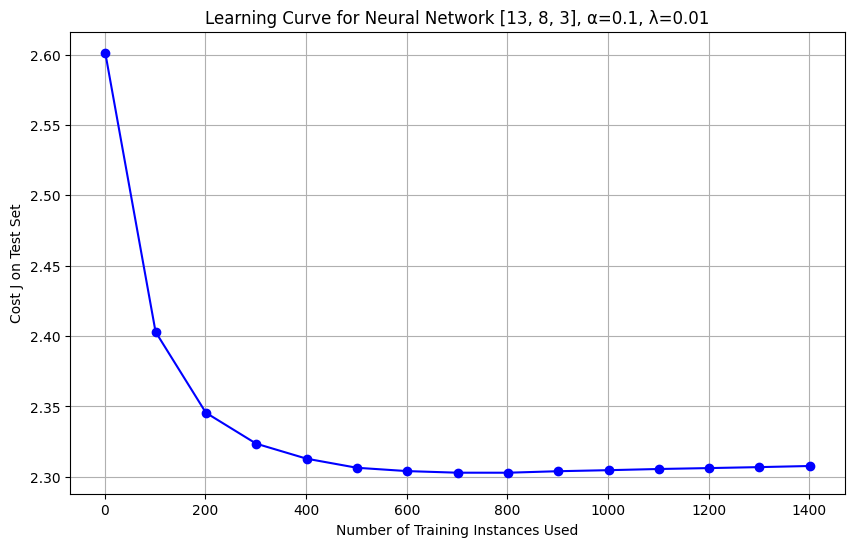

In [ ]:
def learning_curve(X_train, y_train, X_test, y_test, nn, increments=100):
    costs = []
    for i in range(1, len(X_train), increments):
        nn.train(X_train[:i], y_train[:i], iterations=1)
        activations, _ = nn.forward(X_test)
        cost = nn.cost(y_test, activations[-1])
        costs.append(cost)
    return costs

np.random.seed(0)
nn = NN([64, 32, 10], eta=0.1, reg_lambda=0.01, use_softmax=True)
costs = learning_curve(X_train, y_train, X_test, y_test, nn)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X_train), 100), costs, marker='o', linestyle='-', color='b')
plt.title('Learning Curve for Neural Network [13, 8, 3], α=0.1, λ=0.01')
plt.xlabel('Number of Training Instances Used')
plt.ylabel('Cost J on Test Set')
plt.grid(True)
plt.show()

As the number of instances increases the value of the cost function J decreases converging to 2.30 almost (lower bound):

As the number of training instances increases the neural network begins to capture more comprehensive information about the data distribution this reduces the variance in the estimate of the model's parameters. The model's weights and biases converge towards values that generalize better over the entire data distribution.

With fewer training instances a neural network is more prone to overfitting but as we increase the number of training instances each noise has less influence on the overall learning process which generally leads to a reduction in overfitting allowing the model to learn more generalizable patterns that is reflected in the decreasing cost function J.

With more data, the gradient descent process can estimate the gradient of the cost function more accurately because it has more examples. This helps the network find a lower minimum of the cost function.

As more training data becomes available the model learns to recognize underlying patterns  in the data better, which helps in reducing the cost.

The convergence of the cost function J to about 2.30 suggests that the model is approaching a steady state where adding more training instances does not significantly change the outcome. This steady state might be the best achievable performance given the current model architecture and hyperparameter settings.


# k-NN Algorithm

Please note that we used Cyril's implementation of k-NN here.

In [ ]:
class KNN:
    def __init__(self, k):
        self.k = k

    def train(self, features, labels):
        self.features_train = features
        self.labels_train = labels

    def calculate_distances(self, x_test_point):
        euclidean_distances = np.sqrt(np.sum((self.features_train - x_test_point) ** 2, axis=1))
        return pd.DataFrame(data=euclidean_distances, columns=['distance'])

    def find_nearest_neighbors(self, distances):
        return distances.sort_values(by=['distance'], axis=0)[:self.k]

    def most_commonlabel(self, nearest_neighbors):
        nearest_labels = self.labels_train[nearest_neighbors.index]
        votes = self.count(nearest_labels)
        return max(votes, key=votes.get)

    def count(self, labels):
        counts = {}
        for label in labels:
            if label in counts:
                counts[label] += 1
            else:
                counts[label] = 1
        return counts

    def classify(self, test_features):
        predictions = []
        for x_test_point in test_features:
            distances = self.calculate_distances(x_test_point)
            nearest_neighbors = self.find_nearest_neighbors(distances)
            prediction = self.most_commonlabel(nearest_neighbors)
            predictions.append(prediction)
        return predictions

In [ ]:
def accuracy_1D(Y, predictions):
    accuracy = np.mean(predictions == Y)
    return accuracy * 100

def f1_score_1D(Y, predictions):
    classes = np.unique(Y)
    f1_scores = []
    for c in classes:
        tp = np.sum((predictions == c) & (Y == c))
        fp = np.sum((predictions == c) & (Y != c))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        fn = np.sum((predictions != c) & (Y == c))
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    avg_f1 = np.mean(f1_scores) * 100
    return avg_f1

In [ ]:
digits = datasets.load_digits()
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    data, digits.target, test_size=0.2, shuffle=True
)
X_train1 = np.asarray(X_train1)
X_test1 = np.asarray(X_test1)
y_train1 = np.asarray(y_train1)
y_test1 = np.asarray(y_test1)
X_train1, X_test1 = normalize(X_train1, X_test1)

In [ ]:
knn = KNN(3)
knn.train(X_train1, y_train1)
train_predictions2 = knn.classify(X_train1)
test_predictions2 =  knn.classify(X_test1)
train_accuracy2 = accuracy_1D(y_train1, train_predictions2)
print(f"Training Accuracy: {train_accuracy2:.2f}%")
test_accuracy2 = accuracy_1D(y_test1, test_predictions2)
print(f"Testing Accuracy: {test_accuracy2:.2f}%")

Training Accuracy: 99.03%
Testing Accuracy: 98.89%


In [ ]:
X1 = np.asarray(data)
y1 = np.asarray(digits.target)
k_values = [1, 11] + list(range(31, 609, 40))
results = {k: {'train_acc': [], 'test_acc': [], 'train_f1': [], 'test_f1': []} for k in k_values}

for k in k_values:
    pairs = stratified_cross_validation(X1, y1, k=10)
    for train_indices, test_indices in pairs:
        features_train, labels_train = X1[train_indices], y1[train_indices]
        features_test, labels_test = X1[test_indices], y1[test_indices]
        features_train, features_test = normalize(features_train, features_test)
        model = KNN(k)
        model.train(features_train, labels_train)
        training_pred = model.classify(features_train)
        testing_pred = model.classify(features_test)
        training_accuracy = accuracy_1D(labels_train, training_pred)
        testing_accuracy = accuracy_1D(labels_test, testing_pred)
        training_f1 = f1_score_1D(labels_train, training_pred)
        testing_f1 = f1_score_1D(labels_test, testing_pred)
        results[k]['train_acc'].append(training_accuracy)
        results[k]['test_acc'].append(testing_accuracy)
        results[k]['train_f1'].append(training_f1)
        results[k]['test_f1'].append(testing_f1)

for k in results:
    results[k]['avg_train_acc'] = np.mean(results[k]['train_acc'])
    results[k]['avg_test_acc'] = np.mean(results[k]['test_acc'])
    results[k]['std_train_acc'] = np.std(results[k]['train_acc'])
    results[k]['std_test_acc'] = np.std(results[k]['test_acc'])
    results[k]['avg_train_f1'] = np.mean(results[k]['train_f1'])
    results[k]['avg_test_f1'] = np.mean(results[k]['test_f1'])
    results[k]['std_train_f1'] = np.std(results[k]['train_f1'])
    results[k]['std_test_f1'] = np.std(results[k]['test_f1'])


for k in sorted(results.keys()):
    print(f"k={k}: Train Acc: {results[k]['avg_train_acc']:.2f}%, Test Acc: {results[k]['avg_test_acc']:.2f}%, "
          f"Train F1: {results[k]['avg_train_f1']:.2f}%, Test F1: {results[k]['avg_test_f1']:.2f}%")


k=1: Train Acc: 100.00%, Test Acc: 98.72%, Train F1: 100.00%, Test F1: 98.72%
k=11: Train Acc: 98.83%, Test Acc: 98.05%, Train F1: 98.83%, Test F1: 98.03%
k=31: Train Acc: 97.08%, Test Acc: 96.72%, Train F1: 97.06%, Test F1: 96.68%
k=71: Train Acc: 94.35%, Test Acc: 94.04%, Train F1: 94.32%, Test F1: 94.00%
k=111: Train Acc: 92.30%, Test Acc: 91.95%, Train F1: 92.25%, Test F1: 91.90%
k=151: Train Acc: 90.95%, Test Acc: 90.77%, Train F1: 90.89%, Test F1: 90.67%
k=191: Train Acc: 90.03%, Test Acc: 89.99%, Train F1: 89.96%, Test F1: 89.91%
k=231: Train Acc: 89.00%, Test Acc: 88.71%, Train F1: 88.90%, Test F1: 88.55%
k=271: Train Acc: 87.92%, Test Acc: 87.58%, Train F1: 87.79%, Test F1: 87.39%
k=311: Train Acc: 86.71%, Test Acc: 86.14%, Train F1: 86.56%, Test F1: 85.94%
k=351: Train Acc: 85.50%, Test Acc: 85.30%, Train F1: 85.31%, Test F1: 85.10%
k=391: Train Acc: 84.07%, Test Acc: 83.91%, Train F1: 83.83%, Test F1: 83.55%
k=431: Train Acc: 82.40%, Test Acc: 82.25%, Train F1: 82.12%, Test 

I chose to use the kNN algorithm as the second algorithm because
it is extremely simple and effective. It classifies new instances based on the distance between nearest neighbors and it has been shown to perform very well on simple classification problems.
Since each digit forms a specific pattern in pixel space, kNN can effectively distinguish between these patterns by comparing the distances between pixel values. It compares the grayscale intensity and position of pixels in images to make classifications, making it a good algorithm at recognizing patterns formed by digits.

knn can also save computational resources and time and it's robust against noisy data, especially if a good distance metric and an appropriate k value are chosen.

With 1797 instances, the dataset is well within the manageable range for kNN to perform well

**Question 4.** Given the observation above, you should first show, in a table, the performance of each algorithm
(on a given dataset) under a few selected hyper-parameters. You should evaluate at least 3 hyperparameter settings. After analyzing the performance of each algorithm under different hyper-parameters,
identify the best hyper-parameter setting—that is, the set of hyper-parameters that resulted in the best
performance for the corresponding algorithm on a particular dataset.


In [ ]:
knn_res = {
    'k': [],
    'Average Train Accuracy (%)': [],
    'STD Train Accuracy (%)': [],
    'Average Test Accuracy (%)': [],
    'STD Test Accuracy (%)': [],
    'Average Train F1 (%)': [],
    'STD Train F1 (%)': [],
    'Average Test F1 (%)': [],
    'STD Test F1 (%)': []
}

for k in sorted(results.keys()):
    knn_res['k'].append(k)
    knn_res['Average Train Accuracy (%)'].append(results[k]['avg_train_acc'])
    knn_res['STD Train Accuracy (%)'].append(results[k]['std_train_acc'])
    knn_res['Average Test Accuracy (%)'].append(results[k]['avg_test_acc'])
    knn_res['STD Test Accuracy (%)'].append(results[k]['std_test_acc'])
    knn_res['Average Train F1 (%)'].append(results[k]['avg_train_f1'])
    knn_res['STD Train F1 (%)'].append(results[k]['std_train_f1'])
    knn_res['Average Test F1 (%)'].append(results[k]['avg_test_f1'])
    knn_res['STD Test F1 (%)'].append(results[k]['std_test_f1'])

df = pd.DataFrame(data)
print(df.to_string(index=False))

  k  Average Train Accuracy (%)  STD Train Accuracy (%)  Average Test Accuracy (%)  STD Test Accuracy (%)  Average Train F1 (%)  STD Train F1 (%)  Average Test F1 (%)  STD Test F1 (%)
  1                  100.000000                0.000000                  98.722280               0.493959            100.000000          0.000000            98.718191         0.491409
 11                   98.831422                0.124604                  98.046855               0.979694             98.826778          0.124428            98.034531         0.990168
 31                   97.075381                0.106913                  96.718103               1.232974             97.055550          0.108212            96.676524         1.298496
 71                   94.348312                0.272828                  94.040422               1.437873             94.319556          0.269477            94.003485         1.440587
111                   92.302082                0.183761                  91.9489

At k=1, the model perfectly fits the training data but might overfit as indicated by a slight drop in test accuracy. At high k values, the model underfits, as indicated by both lower training and testing performance.

The value of k such that the mean accuracy on the testng and training is high (same with F1 score) and with low standard deviation of accuracy (and F1) is k=11. This is the most optimal value od k from the values I've tried. Since for k=1 it's important to consider the risk of overfitting at such a low k value, as the model perfectly fits the training data.This is why we choose k=11 where there is trade-off between bias and variance with less risk of overfitting.

<ipython-input-21-d704ace14901>:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(ks, avg_train_accs, yerr=std_train_accs, fmt='-o', capsize=5, capthick=2, ecolor='red', color='blue', marker='s', markersize=7, label='Average Training Accuracy')


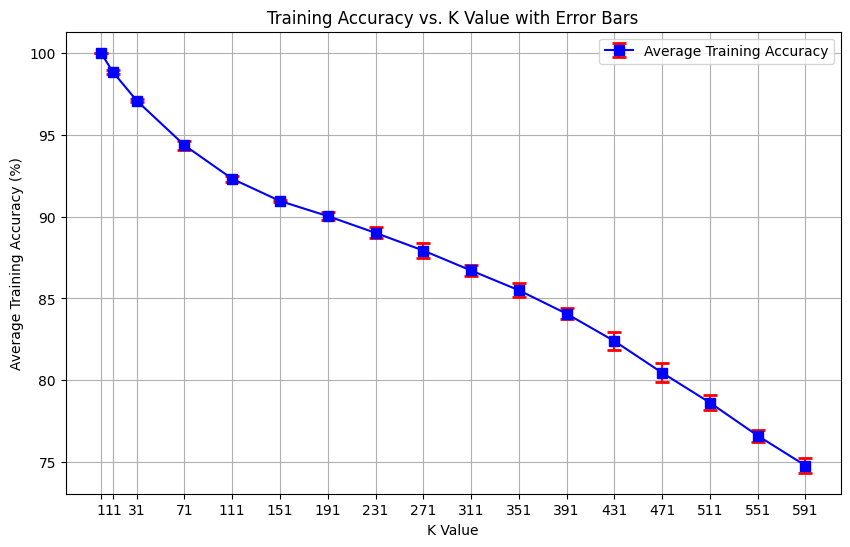

In [ ]:
ks = sorted(results.keys())
avg_train_accs = [results[k]['avg_train_acc'] for k in ks]
std_train_accs = [results[k]['std_train_acc'] for k in ks]
plt.figure(figsize=(10, 6))
plt.errorbar(ks, avg_train_accs, yerr=std_train_accs, fmt='-o', capsize=5, capthick=2, ecolor='red', color='blue', marker='s', markersize=7, label='Average Training Accuracy')
plt.title('Training Accuracy vs. K Value with Error Bars')
plt.xlabel('K Value')
plt.ylabel('Average Training Accuracy (%)')
plt.xticks(ks)
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-22-90c190767511>:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(ks, avg_test_accs, yerr=std_test_accs, fmt='-o', capsize=5, capthick=2, ecolor='red', color='blue', marker='s', markersize=7, label='Average Training Accuracy')


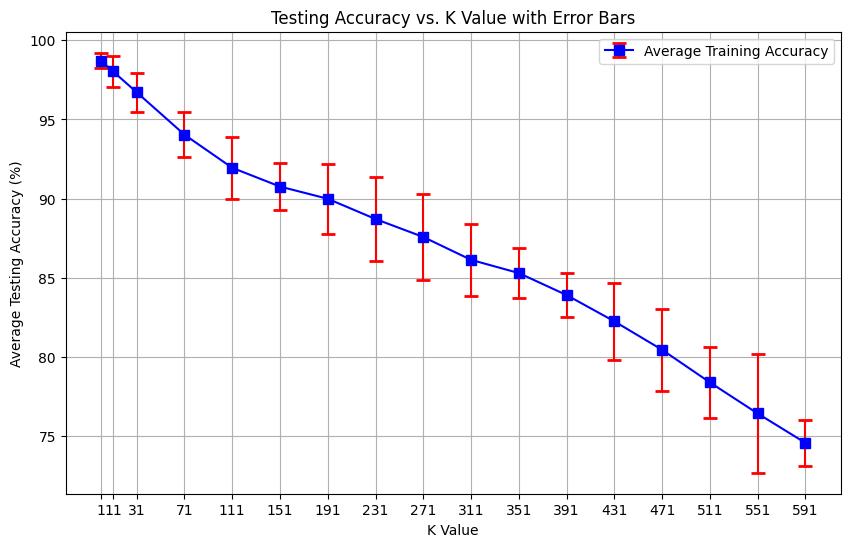

In [ ]:
avg_test_accs = [results[k]['avg_test_acc'] for k in ks]
std_test_accs = [results[k]['std_test_acc'] for k in ks]
plt.figure(figsize=(10, 6))
plt.errorbar(ks, avg_test_accs, yerr=std_test_accs, fmt='-o', capsize=5, capthick=2, ecolor='red', color='blue', marker='s', markersize=7, label='Average Training Accuracy')
plt.title('Testing Accuracy vs. K Value with Error Bars')
plt.xlabel('K Value')
plt.ylabel('Average Testing Accuracy (%)')
plt.xticks(ks)
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-23-980ec63287e7>:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(ks, avg_test_f1s, yerr=std_test_f1s, fmt='-o', capsize=5, capthick=2, ecolor='red', color='blue', marker='s', markersize=7, label='Average Training Accuracy')


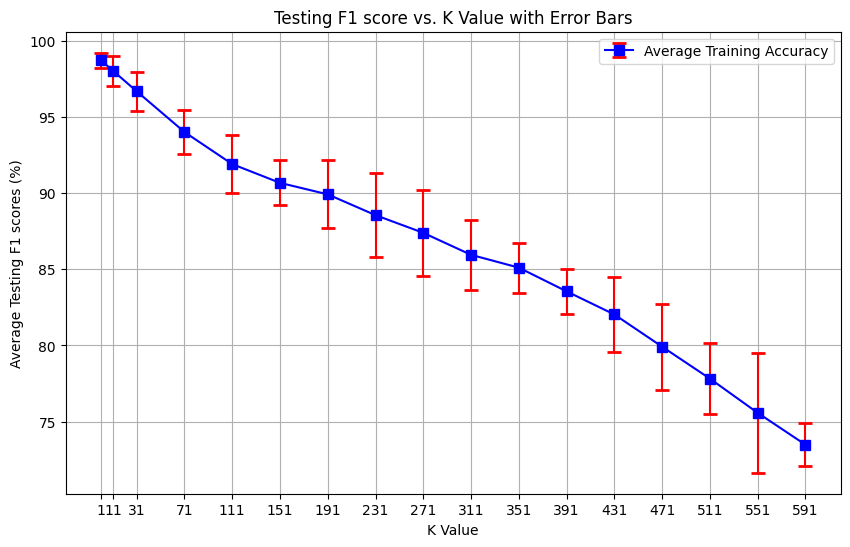

In [ ]:
avg_test_f1s = [results[k]['avg_test_f1'] for k in ks]
std_test_f1s = [results[k]['std_test_f1'] for k in ks]
plt.figure(figsize=(10, 6))
plt.errorbar(ks, avg_test_f1s, yerr=std_test_f1s, fmt='-o', capsize=5, capthick=2, ecolor='red', color='blue', marker='s', markersize=7, label='Average Training Accuracy')
plt.title('Testing F1 score vs. K Value with Error Bars')
plt.xlabel('K Value')
plt.ylabel('Average Testing F1 scores (%)')
plt.xticks(ks)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
k_11= {'train_acc': [], 'test_acc': [], 'train_f1': [], 'test_f1': []}
k = 11
pairs = stratified_cross_validation(X1, y1, k=10)
for train_indices, test_indices in pairs:
    features_train, labels_train = X1[train_indices], y1[train_indices]
    features_test, labels_test = X1[test_indices], y1[test_indices]
    features_train, features_test = normalize(features_train, features_test)
    model = KNN(k)
    model.train(features_train, labels_train)
    training_pred = model.classify(features_train)
    testing_pred = model.classify(features_test)
    training_accuracy = accuracy_1D(labels_train, training_pred)
    testing_accuracy = accuracy_1D(labels_test, testing_pred)
    training_f1 = f1_score_1D(labels_train, training_pred)
    testing_f1 = f1_score_1D(labels_test, testing_pred)
    k_11['train_acc'].append(training_accuracy)
    k_11['test_acc'].append(testing_accuracy)
    k_11['train_f1'].append(training_f1)
    k_11['test_f1'].append(testing_f1)

The graph showing performance on the training set as a function of k, has an accuracy of 1 when k=1 because in this case each instance’s nearest neighbor is itself, so we’re not comparing it to other
instances in the training set so the model is memorizing the data as it is. However, the accuracy starts dropping after this because now more neighbors are being considered, hence there’s more uncertainty about which class the instances belong to, not all neighbors will share the same label necessarily. We see that the standard deviation is small because the model has already seen and
been trained on this dataset.

As k increases, both training and testing accuracy decrease. This is due to the fact that larger k values tend to smooth the decision boundaries, reducing the model's ability to capture more complex patterns leading to higher bias. It starts considering way to many neighbors and doesn't ignore noise and outliers.

The standard deviations for both training and testing metrics increase as k increases. This indicates that the model becomes less consistent as k increaseslikely due to increased bias and less sensitivity to the data. The graphs showing performance on the testing set show a much higher standard deviation and this is mainly because the instances in that dataset are new to the model and have not been used during its training it shows the uncertainty this model faces when making new
predictions.

At k=1, the model perfectly fits the training data but might overfit as indicated by a slight drop in test accuracy.
At high k values, the model underfits, as indicated by both lower training and testing performance.


The value of k such that the mean accuracy on the testng and training is high (same with F1 score) and with low standard
deviation of accuracy (and F1) is k=11. This is the most optimal value od k from the values I've tried. Since for k=1 it's important to consider the risk of overfitting at such a low k value, as the model perfectly fits the training data.This is why we choose k=11 where there is trade-off between bias and variance with less risk of overfitting.


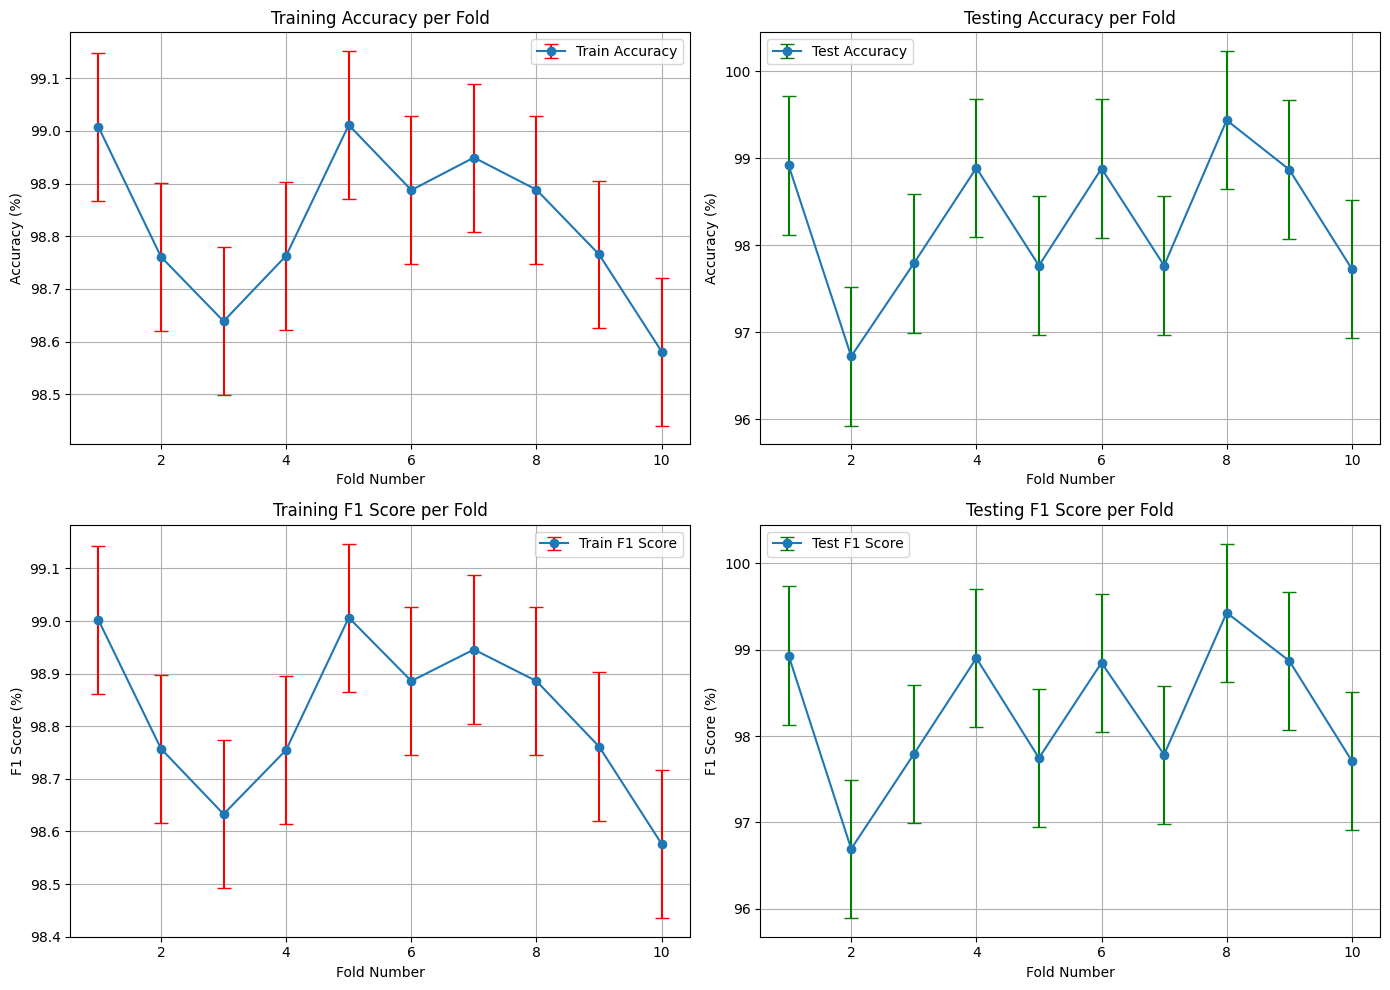

In [ ]:
folds = list(range(1, len(k_11['train_acc']) + 1))
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
error_color_train = 'red'
error_color_test = 'green'
axes[0, 0].errorbar(folds, k_11['train_acc'], yerr=np.std(k_11['train_acc']), label='Train Accuracy', fmt='-o', capsize=5, ecolor=error_color_train)
axes[0, 0].set_title('Training Accuracy per Fold')
axes[0, 0].set_xlabel('Fold Number')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 1].errorbar(folds, k_11['test_acc'], yerr=np.std(k_11['test_acc']), label='Test Accuracy', fmt='-o', capsize=5, ecolor=error_color_test)
axes[0, 1].set_title('Testing Accuracy per Fold')
axes[0, 1].set_xlabel('Fold Number')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[1, 0].errorbar(folds, k_11['train_f1'], yerr=np.std(k_11['train_f1']), label='Train F1 Score', fmt='-o', capsize=5, ecolor=error_color_train)
axes[1, 0].set_title('Training F1 Score per Fold')
axes[1, 0].set_xlabel('Fold Number')
axes[1, 0].set_ylabel('F1 Score (%)')
axes[1, 0].legend()
axes[1, 0].grid(True)
axes[1, 1].errorbar(folds, k_11['test_f1'], yerr=np.std(k_11['test_f1']), label='Test F1 Score', fmt='-o', capsize=5, ecolor=error_color_test)
axes[1, 1].set_title('Testing F1 Score per Fold')
axes[1, 1].set_xlabel('Fold Number')
axes[1, 1].set_ylabel('F1 Score (%)')
axes[1, 1].legend()
axes[1, 1].grid(True)
plt.tight_layout()
plt.show()

We can see that with k=11 we're achieving high testing accuracies between 96.7% and 99.4% almost with a standard deviation relatively low across each fold, similar somehow to the one observed in the training graph. While our training accuracies are between 98.6% and 99%.

Similarly f1 scores for the test sets are between 96.8% and 99.4% with relatively small std similar to the ones in the training sets. While the training f1 scores range between 98.6% and 99%.

The relatively low standard deviation in accuracy and F1 scores across different folds suggests that the model is robust to variations within the data when k=11. The consistency in performance indicates that the dataset is well-balanced and uniformly distributed across the digit classes, which helps maintain performance regardless of how the data is split.

Selecting k=11 appears to be an effective balance that avoids overfitting which is common with very low k values where the model can overly be affected by noise and underfitting common with very high k values leading to overly generalized models. A k value of 11 ensures that the model is neither too sensitive to noise in the data nor too general, leading to high accuracy and F1 scores as the model can generalize well from the training data to unseen test data.
